# MathStyleModel

In [10]:
import numpy as np
from math_vocab import MathVocab
from vocabulary import BOS_CODE
from style_dataset import StyleDataset
from math_dataset import MathDataset
from utils import words_to_sent

voc_path        = "data/math_style/math_vocab.data"
tr_dataset_path = "data/math_style/math_dataset_%d_train.data"
va_dataset_path = "data/math_style/math_dataset_%d_valid.data"
model_path      = 'models/math/style-autoencoder-003/'

## Vocabulary

In [11]:
voc = MathVocab()
voc.restore(voc_path)
print(voc)

MathVocab:
  size: 17
  _tokens_to_words: ['<UNK>', '<BOS>', '<EOS>', '<PAD>', '+', '1', '2', '=', ' ', '3', '4', '5', '6', '7', '8', '9', '0']


## Dataset

In [12]:
tr_dataset = StyleDataset(MathDataset)
tr_dataset.restore(tr_dataset_path)
print(tr_dataset)

va_dataset = StyleDataset(MathDataset)
va_dataset.restore(va_dataset_path)
print(va_dataset)

StyleDataset:
  path_0: data/math_style/math_dataset_0_train.data
  path_1: data/math_style/math_dataset_1_train.data
  shape: [20000, 34]

StyleDataset:
  path_0: data/math_style/math_dataset_0_valid.data
  path_1: data/math_style/math_dataset_1_valid.data
  shape: [20000, 34]



## Model

In [13]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats_ex

class StyleAutoencoder:
    def __init__(self):
        self._scope    = 'style_autoencoder'
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []
        self.va_losses = []
    
    
    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses, self.va_losses], 
                    open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
        
    def restore(self, path):
        try:
            [self.tr_epoch, self.tr_step, self.tr_losses, self.va_losses] = pickle.load(
                open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)
        
    
    def get_embeddings(self):
        return self.embedding.eval(self._sess)
    
        
    def _make_loss(self, logits, labels):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits = logits,
            labels = labels)
        return tf.reduce_mean(loss)
    

    def _make_optimizer(self, loss, lr, grad_clip):
        tr_vars   = tf.trainable_variables()
        grads, _  = tf.clip_by_global_norm(tf.gradients(loss, tr_vars), grad_clip)
        train_op  = tf.train.AdamOptimizer(lr)
        optimizer = train_op.apply_gradients(zip(grads, tr_vars))
        return optimizer
    
    # =====================================================================
    
    def _make_rnn_cell(self, num_units, num_layers, keep_prob):
        def make_layer():
            l = tf.contrib.rnn.BasicLSTMCell(num_units)
            l = tf.contrib.rnn.DropoutWrapper(l, output_keep_prob=keep_prob)
            return l        
        return tf.contrib.rnn.MultiRNNCell([make_layer() for _ in range(num_layers)])
    
    
    def _make_decoder(self, inp, h, num_units, num_layers, voc_size, seq_len, keep_prob):
        cell = self._make_rnn_cell(num_units, num_layers, keep_prob)
        logits_seq = []

        def loop_function(outputs):
            logits = tf.layers.dense(outputs, voc_size, name='projection')
            token = tf.argmax(logits, axis=1)
            inp = tf.nn.embedding_lookup(self.embedding, token)
            return inp, logits
            
        with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
            zeros = tf.zeros_like(h)
            state = (tf.nn.rnn_cell.LSTMStateTuple(zeros, zeros),
                     tf.nn.rnn_cell.LSTMStateTuple(zeros, h))
            
            for t in range(seq_len):
                output, state = cell.apply(inp, state)
                inp, logits = loop_function(output)
                logits_seq.append(tf.expand_dims(logits, 1))

        return tf.concat(logits_seq, axis=1)
    
    
    def build(self, voc_size, bos_token, emb_size, seq_len, num_units, num_layers, grad_clip=5):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default(), tf.variable_scope(self._scope):
            # placeholders
            self.enc_inputs_pl = tf.placeholder(tf.int32, [None, None], name='enc_inputs')
            self.targets_pl    = tf.placeholder(tf.int32, [None, None], name='targets')
            self.styles_pl     = tf.placeholder(tf.int32, shape=[None], name='styles')
            self.batch_size_pl = tf.placeholder(tf.int32, shape=[], name='batch_size')
            self.keep_prob_pl  = tf.placeholder(tf.float32, name='keep_prob')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # embedding
            self.embedding     = tf.Variable(tf.random_normal(shape=[voc_size, emb_size], dtype=tf.float32))
            en_inputs          = tf.nn.embedding_lookup(self.embedding, self.enc_inputs_pl)
            bos_tokens         = tf.tile([bos_token], tf.expand_dims(self.batch_size_pl,0))  
            de_inputs          = tf.nn.embedding_lookup(self.embedding, bos_tokens)
            
            # encoder
            en_cell            = self._make_rnn_cell(num_units, num_layers, self.keep_prob_pl)
            en_initial_state   = en_cell.zero_state(self.batch_size_pl, tf.float32)
            seq_lens           = tf.tile([seq_len], tf.expand_dims(self.batch_size_pl,0))
            _, en_state        = tf.nn.dynamic_rnn(en_cell, en_inputs, seq_lens, en_initial_state, scope='encoder')
            
            # latent vector = [content, style]
            style_num  = 2
            style_vec  = tf.one_hot(self.styles_pl, style_num)
            content_style = tf.concat([en_state[~0].h, style_vec], axis = 1)

            # decoder
            de_logits = self._make_decoder(
                inp        = de_inputs, 
                h          = content_style, 
                num_units  = num_units+style_num, 
                num_layers = num_layers,
                voc_size   = voc_size,
                seq_len    = seq_len, 
                keep_prob  = self.keep_prob_pl)

            # prediction
            self.outputs       = tf.argmax(tf.nn.softmax(de_logits), axis=2)

            # training
            self.loss_op       = self._make_loss(de_logits, self.targets_pl)
            self.train_op      = self._make_optimizer(self.loss_op, self.lr_pl, grad_clip)
            
            # utils
            self.init_op       = tf.global_variables_initializer()
            self._saver        = tf.train.Saver()

        # session
        self._sess = tf.Session(graph=self._graph)
        self._sess.run(self.init_op)
        
    # =====================================================================
    

    def train(self, tr_dataset, va_dataset, 
              step_num,  batch_size, learning_rate, keep_prob=.5, log_every=20, mean_win=30):
        try:
            data_size = tr_dataset.get_data_size()
            for self.tr_step in range(self.tr_step, step_num-1):
                ep = self.tr_step*batch_size/data_size
                # Train
                sents, styles = tr_dataset.get_next_batch(batch_size)
                tr_loss, _ = self._sess.run(
                    [self.loss_op, self.train_op], 
                    feed_dict = {
                        self.enc_inputs_pl: sents,
                        self.targets_pl   : sents,
                        self.styles_pl    : styles,
                        self.batch_size_pl: batch_size,
                        self.keep_prob_pl : keep_prob,
                        self.lr_pl        : learning_rate,
                })
                self.tr_losses.append(tr_loss)
                # Eval
                if self.tr_step % log_every == log_every-1:
                    sents, styles = va_dataset.get_next_batch(batch_size)
                    va_loss = self._sess.run(
                        self.loss_op, 
                        feed_dict={
                            self.enc_inputs_pl: sents,
                            self.targets_pl   : sents,
                            self.styles_pl    : styles,
                            self.batch_size_pl: batch_size,
                            self.keep_prob_pl : keep_prob,
                            self.lr_pl        : learning_rate,
                        })
                    self.va_losses.extend([va_loss]*log_every)
                    show_train_stats_ex(ep, self.tr_step, self.tr_losses, self.va_losses, mean_win)
                        
        except KeyboardInterrupt:
            show_train_stats_ex(ep, self.tr_step, self.tr_losses, self.va_losses, mean_win)
            

    def run(self, sents, styles, batch_size, seq_length):
        return self._sess.run(
            self.outputs, 
            feed_dict = {
                self.enc_inputs_pl: sents,
                self.targets_pl   : sents,
                self.styles_pl    : styles,
                self.batch_size_pl: batch_size,
                self.keep_prob_pl : 1,
        })


## Build

In [14]:
%%time
model = StyleAutoencoder()
seq_len = tr_dataset.get_seq_len()
assert seq_len == va_dataset.get_seq_len()

model.build(
    voc_size   = voc.size, 
    bos_token  = BOS_CODE,
    seq_len    = seq_len,
    emb_size   = 100, 
    num_units  = 256, 
    num_layers = 2)

CPU times: user 7.02 s, sys: 92.2 ms, total: 7.11 s
Wall time: 7.11 s


## Train

In [16]:
%%time
%matplotlib inline

model.train(
    step_num      = 50000,
    batch_size    = 64, 
    learning_rate = 1e-3, 
    mean_win      = 30,
    log_every     = 10,
    tr_dataset    = tr_dataset,
    va_dataset    = va_dataset,
)
model.save(model_path)

ResourceExhaustedError: OOM when allocating tensor with shape[64,1032]
	 [[Node: style_autoencoder/decoder/decoder/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul_10 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](style_autoencoder/decoder/decoder/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/concat_10, style_autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/read)]]
	 [[Node: style_autoencoder/Mean/_63 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_13486_style_autoencoder/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'style_autoencoder/decoder/decoder/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-2e394f5386c3>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'model = StyleAutoencoder()\nseq_len = tr_dataset.get_seq_len()\nassert seq_len == va_dataset.get_seq_len()\n\nmodel.build(\n    voc_size   = voc.size, \n    bos_token  = BOS_CODE,\n    seq_len    = seq_len,\n    emb_size   = 100, \n    num_units  = 256, \n    num_layers = 2)')
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2131, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/magics/execution.py", line 1238, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 11, in <module>
  File "<ipython-input-13-57365299c6bb>", line 122, in build
    keep_prob  = self.keep_prob_pl)
  File "<ipython-input-13-57365299c6bb>", line 78, in _make_decoder
    output, state = cell.apply(inp, state)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/rnn_cell_impl.py", line 183, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/rnn_cell_impl.py", line 1066, in call
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/rnn_cell_impl.py", line 891, in __call__
    output, new_state = self._cell(inputs, state, scope)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/rnn_cell_impl.py", line 183, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/rnn_cell_impl.py", line 441, in call
    value=self._linear([inputs, h]), num_or_size_splits=4, axis=1)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/rnn_cell_impl.py", line 1189, in __call__
    res = math_ops.matmul(array_ops.concat(args, 1), self._weights)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2437, in _mat_mul
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,1032]
	 [[Node: style_autoencoder/decoder/decoder/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/MatMul_10 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](style_autoencoder/decoder/decoder/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/concat_10, style_autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/read)]]
	 [[Node: style_autoencoder/Mean/_63 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_13486_style_autoencoder/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


## Test

In [22]:
batch_size = 10

for dataset in [tr_dataset, va_dataset]:
    print('\n'+'='*80+'\n'+str(dataset))
    inp, styles = dataset.get_next_batch(batch_size)
    styles = 1-styles
    out = model.run(inp, styles, batch_size, seq_len)

    def prepare(s):
        words = voc.to_words(s)
        s = "".join(words)
        s = s.replace('<BOS>', '[').replace('<EOS>', ']').replace('<PAD>', '_')
        return s

    for i in range(len(inp)):
        print('-'*50)
        print(prepare(inp[i]))
        print(prepare(out[i]))



MathStyleDataset:
  path_0: data/math_style/math_dataset_0_train.data
  path_1: data/math_style/math_dataset_1_train.data
  shape: [20000, 34]

--------------------------------------------------
[4+14+1 = 3+7+1+1+2+5]____________
[4+14+1=3+7+1+1+2+1+5]____________
--------------------------------------------------
[5+1+1+7 = 4+10]__________________
[5+1+1+7=4+1+10]__________________
--------------------------------------------------
[17 = 6+9+2]______________________
[17=5+9+5+1]______________________
--------------------------------------------------
[2+3+2+1+1+6 = 3+1+5+6]___________
[2+3+2+1+1+7=3+1+4+4+6]___________
--------------------------------------------------
[10+6 = 13+1+2]___________________
[10+6=13+1+2]_____________________
--------------------------------------------------
[7+5+1=5+8]_______________________
[7+5+1 = 5+8]_____________________
--------------------------------------------------
[4+4+2=3+1+4+2]___________________
[4+4+2 = 3+2+2]___________________
--------

## Embeddings

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

embeddings = model.get_embeddings()
print(embeddings.shape)

(17, 100)


[16, 5, 6, 9, 10, 11, 12, 13, 14, 15]


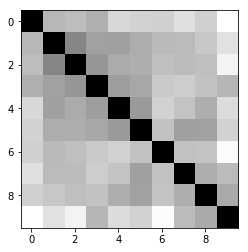

In [19]:
from itertools import product
digits = voc.to_tokens(list("0123456789"))
print(digits)
emb = embeddings[digits,:]

dist = np.zeros([10,10])
for i,j in product(range(10), range(10)):
    a,b = emb[i], emb[j]
    dist[i,j] = np.sum((a-b)**2)
    
plt.imshow(dist, cmap='gray');

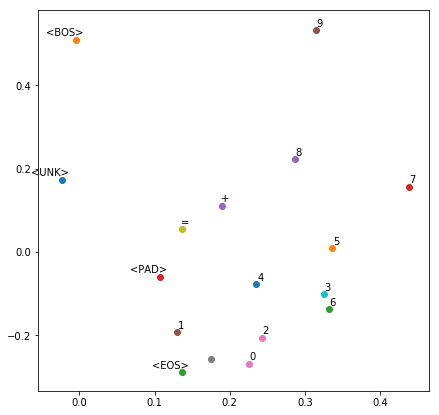

In [20]:
la = np.linalg
words = voc.to_words(range(voc.size))

start = 0

X =  embeddings[start:]

U,S,V = la.svd(X)
n = len(X)
plt.figure(figsize=(7,7))

for i in range(n):
    x,y,w = U[i,0], U[i,1], words[start+i]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(7, 2), textcoords="offset points", ha="right", va="bottom")
    #print('%+.2f, %+.2f, %s' % (x, y, w))
plt.show()

## Restore

In [6]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/math/style-autoencoder-002/
